# Requirements

In [1]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

from lightgbm import LGBMClassifier, train, Dataset, Booster
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier


import shap

import optuna

from sklearn.metrics import roc_auc_score

from optuna_tuning import tune_hyperparams # Кастомная функция для тюнинга параметров

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


!mkdir val_preds
!mkdir submissions
!mkdir weights

/home/codespace/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mkdir: cannot create directory ‘val_preds’: File exists
mkdir: cannot create directory ‘submissions’: File exists
mkdir: cannot create directory ‘weights’: File exists


In [2]:
# Считываем данные
X_train = pd.read_parquet('data/X_train_processed.parquet').drop(columns=['partition'])
X_train_full = pd.read_parquet('data/X_train_full_processed.parquet').drop(columns=['partition'])
X_val = pd.read_parquet('data/X_val_processed.parquet')
X_test = pd.read_parquet('data/X_test_processed.parquet')
y_train = pd.read_parquet('data/y_train_processed.parquet')
y_train_full = pd.read_parquet('data/y_train_full_processed.parquet')
y_val = pd.read_parquet('data/y_val_processed.parquet')
sample_submission = pd.read_csv('data/submission_example.csv')
submit = sample_submission.copy()

In [3]:
X_train

,start_time,type,count,time_left_mean,time_left_median,time_left_sum,time_left_std,time_left_min,time_left_max,time_days_mean,...,diff_std,diff_more_than_90,diff_min,diff_max,diff_sum,start_time_left,start_time_days,day_of_week_start,month_start,year_start
0,18109.0,4,2.0,96.50,96.5,193.0,132.228968,3.0,190.0,18317.50,...,-1.000000,1.0,187.0,187.0,187.0,305.0,18109.0,3.0,8.0,2019.0
1,18201.0,4,7.0,131.00,140.0,917.0,40.636601,50.0,177.0,18283.00,...,24.011803,0.0,0.0,68.0,127.0,213.0,18201.0,4.0,11.0,2019.0
2,17866.0,4,18.0,233.50,239.5,4203.0,124.242765,10.0,400.0,18180.50,...,18.433904,0.0,0.0,61.0,390.0,548.0,17866.0,5.0,12.0,2018.0
3,18322.0,4,1.0,44.00,44.0,44.0,-1.000000,44.0,44.0,18370.00,...,-1.000000,0.0,NaN,NaN,0.0,92.0,18322.0,6.0,3.0,2020.0
4,18078.0,4,4.0,206.75,252.5,827.0,136.731793,10.0,312.0,18207.25,...,96.572943,1.0,27.0,210.0,302.0,336.0,18078.0,0.0,7.0,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65109,18017.0,3,1.0,6.00,6.0,6.0,-1.000000,6.0,6.0,18033.00,...,-1.000000,0.0,NaN,NaN,0.0,22.0,18017.0,2.0,5.0,2019.0
65110,18017.0,3,2.0,5.00,5.0,10.0,0.000000,5.0,5.0,18034.00,...,-1.000000,0.0,0.0,0.0,0.0,22.0,18017.0,2.0,5.0,2019.0
65111,18017.0,3,2.0,1.00,1.0,2.0,0.000000,1.0,1.0,18038.00,...,-1.000000,0.0,0.0,0.0,0.0,22.0,18017.0,2.0,5.0,2019.0
65112,18017.0,3,1.0,4.00,4.0,4.0,-1.000000,4.0,4.0,18035.00,...,-1.000000,0.0,NaN,NaN,0.0,22.0,18017.0,2.0,5.0,2019.0


In [4]:
cat_cols = ['type']
num_cols = [col for col in X_train if col not in cat_cols]

In [5]:
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

# Нормируем числовые переменные: приводим данные в валидации к масштабу трейна, данные в тесте к масштабу полного трейна
X_val_scaled[num_cols] = X_val[num_cols] * X_train[num_cols].mean() / X_val[num_cols].mean()
X_test_scaled[num_cols] = X_test_scaled[num_cols] * X_train_full[num_cols].mean() / X_test[num_cols].mean()

# Optuna

## Catboost

In [6]:
# %%time

# params, auc_c = tune_hyperparams(X_train, X_val_scaled, y_train, y_val,
#       model='catboost', n_trials=50)

In [7]:
# %%time

# model_c = CatBoostClassifier(**params)
# model_c.fit(X_train, y_train, eval_set = (X_val_scaled, y_val), verbose=100)

# # model_c.load_model(f"checkpoints_boostings/catboost_{auc_c:.4f}.bin")
# iters_c = model_c.best_iteration_ + 1

# val_preds = model_c.predict_proba(X_val_scaled)[:, 1]

# auc_c = roc_auc_score(y_val, val_preds)
# print(f"Best iterations is {iters_c}")
# print("\n Validation AUC: %.4f" % auc_c)

# pd.Series(val_preds).to_csv(f'val_preds/catboost_{auc_c:.4f}.csv', index=False)

In [8]:
# %%time

# params['n_estimators'] = iters_c
# params['use_best_model'] = False

# model_c = CatBoostClassifier(**params)
# model_c.fit(X_train_full, y_train_full, verbose=100)

# test_preds = model_c.predict_proba(X_test_scaled)[:, 1]

# submit['score'] = test_preds

# submit.to_csv(f'submissions/catboost_{auc_c:.4f}.csv', index=False)

# XGBoost

In [9]:
# %%time

# params, auc_x = tune_hyperparams(X_train, X_val_scaled, y_train, y_val,
#       model='xgboost', n_trials=50)

In [10]:
# %%time

# model_x = XGBClassifier(**params)

# model_x.fit(X_train, y_train, eval_set=[(X_val_scaled, y_val)])
# val_preds = model_x.predict_proba(X_val_scaled.values)[:, 1]
# iters_x = model_x.best_iteration + 1

# auc_x = roc_auc_score(y_val, val_preds)
# print(f"Best iterations is {iters_x}")
# print("\n Validation AUC: %.4f" % auc_x)

# pd.Series(val_preds).to_csv(f'val_preds/xgboost_{auc_x:.4f}.csv', index=False)

In [11]:
# %%time

# # params['n_estimators'] = 10

# params_copy = params.copy()
# params_copy['n_estimators'] = iters_x
# del params_copy['early_stopping_rounds']

# model_x = XGBClassifier(**params_copy)

# model_x.fit(X_train_full, y_train_full, verbose=100)
# test_preds = model_x.predict_proba(X_test_scaled.values)[:, 1]


# submit['score'] = test_preds
# submit.to_csv(f'submissions/xgboost_{auc_x:.4f}.csv', index=False)

# LightGBM

In [12]:
# %%time

# # Тюнинг параметров

# params, auc_l = tune_hyperparams(X_train, X_val_scaled, y_train, y_val,
#       model='lightgbm', n_trials=50)

In [13]:
# Уже определены оптимальные параметры

params = {
    'subsample': 0.8865310038369543,
    'learning_rate': 0.13475353156897893,
    'colsample_bytree': 0.7228531773341953,
    'reg_alpha': 0.893320872777366,
    'reg_lambda': 0.6477119263843745,
    'num_leaves': 49,
    'max_depth': 6,
    'min_child_samples': 107,
    'objective': 'binary',
    'n_estimators': 1000,
    'early_stopping_round': 50,
    'random_state': 42,
    'verbosity': -1,
}

In [14]:
# Датасеты для LightGBM

train_l = Dataset(X_train, y_train
)

train_full_l = Dataset(X_train_full, y_train_full
)

val_l = Dataset(X_val_scaled, y_val
)

In [15]:
model_l = train(
    params,
    train_set=train_l,
    valid_sets=(val_l),
)
iters_l = model_l.best_iteration + 1

val_preds = model_l.predict(X_val_scaled)

auc_l = roc_auc_score(y_val, val_preds)
print(f"Best iterations is {iters_l}")
print("\n Validation AUC: %.4f" % auc_l)

# Во время экспериментов лучше сохранять в названии файла точность на валидации
# pd.Series(val_preds).to_csv(f'val_preds/lightgbm_{auc_l:.4f}.csv', index=False)
pd.Series(val_preds).to_csv(f'val_preds/lightgbm.csv', index=False)

[1]	valid_0's binary_logloss: 0.644264
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.625332
[3]	valid_0's binary_logloss: 0.610283
[4]	valid_0's binary_logloss: 0.598327
[5]	valid_0's binary_logloss: 0.588262
[6]	valid_0's binary_logloss: 0.580146
[7]	valid_0's binary_logloss: 0.574097
[8]	valid_0's binary_logloss: 0.570356
[9]	valid_0's binary_logloss: 0.565778
[10]	valid_0's binary_logloss: 0.562816
[11]	valid_0's binary_logloss: 0.559783
[12]	valid_0's binary_logloss: 0.557152
[13]	valid_0's binary_logloss: 0.555354
[14]	valid_0's binary_logloss: 0.553299
[15]	valid_0's binary_logloss: 0.55206
[16]	valid_0's binary_logloss: 0.550926
[17]	valid_0's binary_logloss: 0.55009
[18]	valid_0's binary_logloss: 0.549267
[19]	valid_0's binary_logloss: 0.548539
[20]	valid_0's binary_logloss: 0.548337
[21]	valid_0's binary_logloss: 0.548115
[22]	valid_0's binary_logloss: 0.548334
[23]	valid_0's binary_logloss: 0.548116
[24]	valid_0's binary_logloss:

In [16]:
model_l.save_model('weights/lightgbm.txt', importance_type='gain')

In [17]:
# Инференс

params_copy = params.copy()
params_copy['n_estimators'] = iters_l
del params_copy['early_stopping_round']

model_l = train(
    params_copy,
    train_set=train_full_l,
)
iters_l = model_l.best_iteration + 1

test_preds = model_l.predict(X_test_scaled)

submit['score'] = test_preds
# Во время экспериментов лучше сохранять в названии файла точность на валидации
# submit.to_csv(f'submissions/lightgbm_{auc_l:.4f}.csv', index=False)
submit.to_csv(f'submissions/lightgbm.csv', index=False)

In [18]:
model_l.save_model('weights/lightgbm_without_validation.txt', importance_type='gain')

# Интерпретация модели

In [19]:
# Будем использовать модель, обученную с валидацией
model_l = Booster(model_file='weights/lightgbm.txt')
model_l.params['objective'] = 'binary'

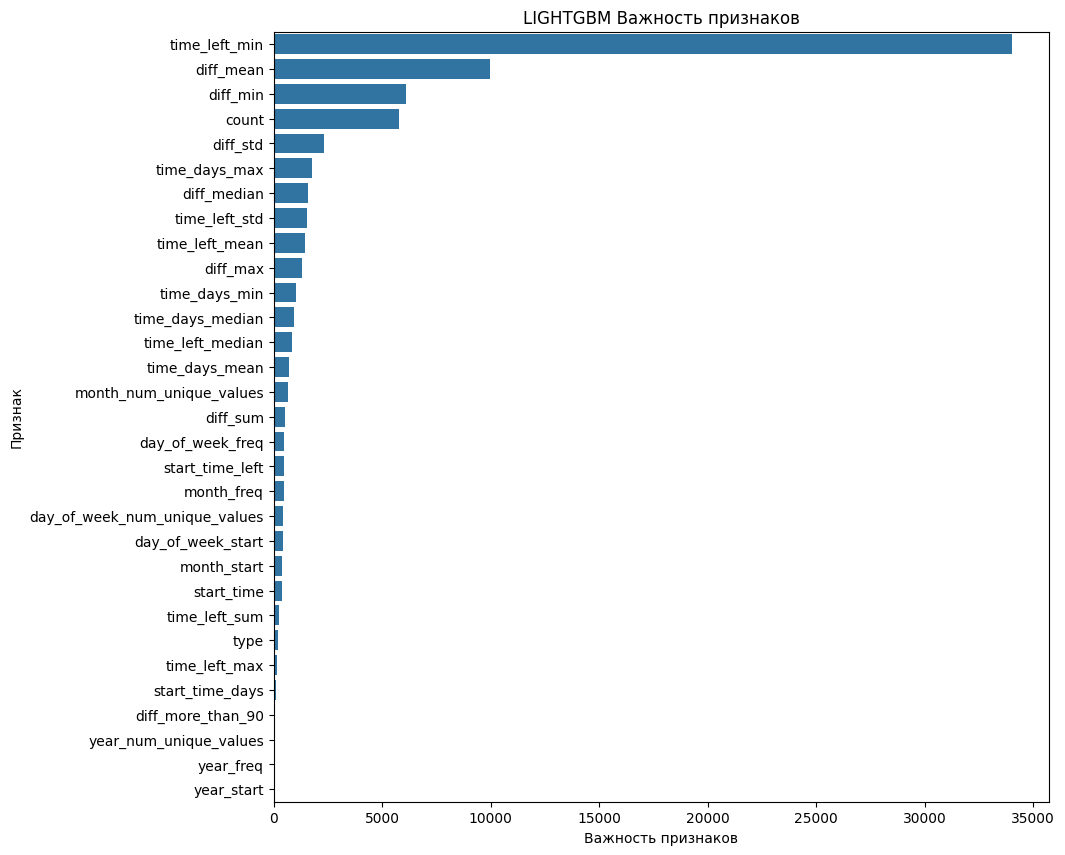

In [20]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    plt.figure(figsize=(10, 10))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' Важность признаков')
    plt.xlabel('Важность признаков')
    plt.ylabel('Признак')
    
plot_feature_importance(model_l.feature_importance(importance_type='gain'), X_train.columns,'LIGHTGBM')

Вы можете видеть важность признаков для модели.
Самые важные: 
1) Сколько дней осталось до 'границы' (начиная с которой идет таргет) во время последнего привлечения
2) Средняя и минимальная разницы между двумя последовательными привлечениями
3) Число привлечений

## Shap

Теперь воспользуемся библиотекой Shap

In [21]:
explainer = shap.TreeExplainer(model_l)
shap_values = explainer(X_val)

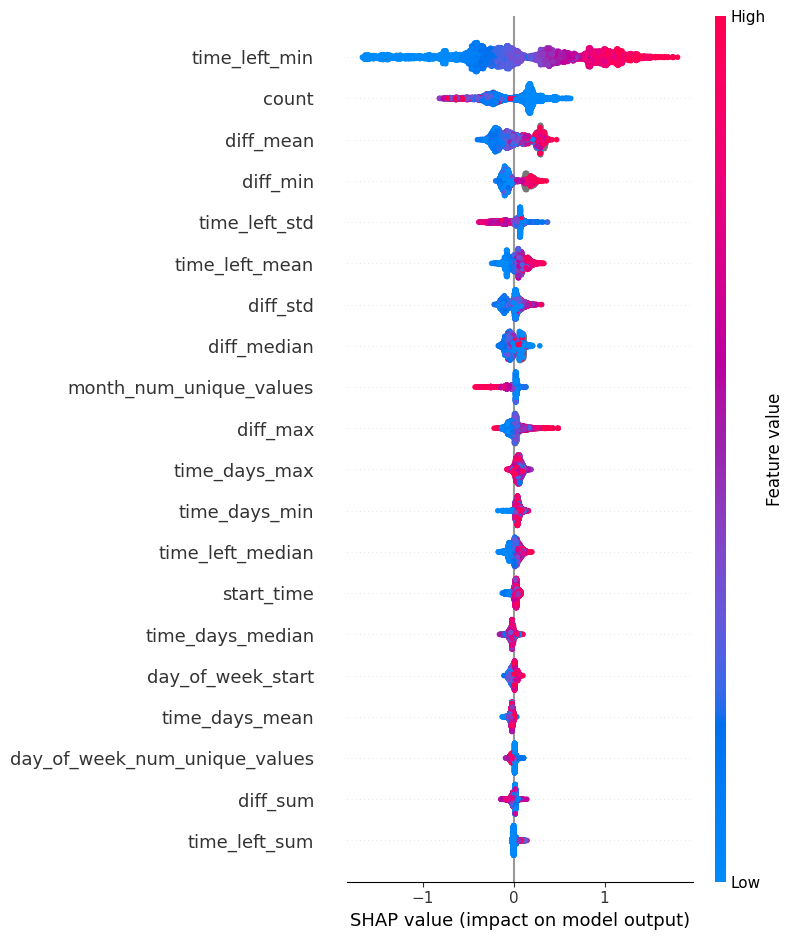

In [22]:
shap.summary_plot(shap_values, X_val)

Здесь Вы можете узнать, как именно влияют признаки на выход модели.

Красные значения соответствуют высоким значениям признака, синие - низким.

Справа расположенные точки означают положительное влияние, слева - негативное.

Например, высокие значения переменной time_left_min положительно влияют на вероятность оттока (это логично, ведь если партнер и так уже давно никого не приводил, то он с меньшей вероятностью кого-то приведет в дальнейшем)

In [23]:
# Можно вывести графики для пар признаков, которые отражают влияние определенной комбинации значений этой пары
# на предсказания модели

# for name in X_val.columns:
#     shap.dependence_plot(name, shap_values.values, X_val, display_features=X_val)

Визуализация отдельного партнера (почему модель выдала именно такую вероятность для него).  
Красные повлияли на положительно (то есть из-за них предсказанная вероятность оттока выше), синие - наоборот

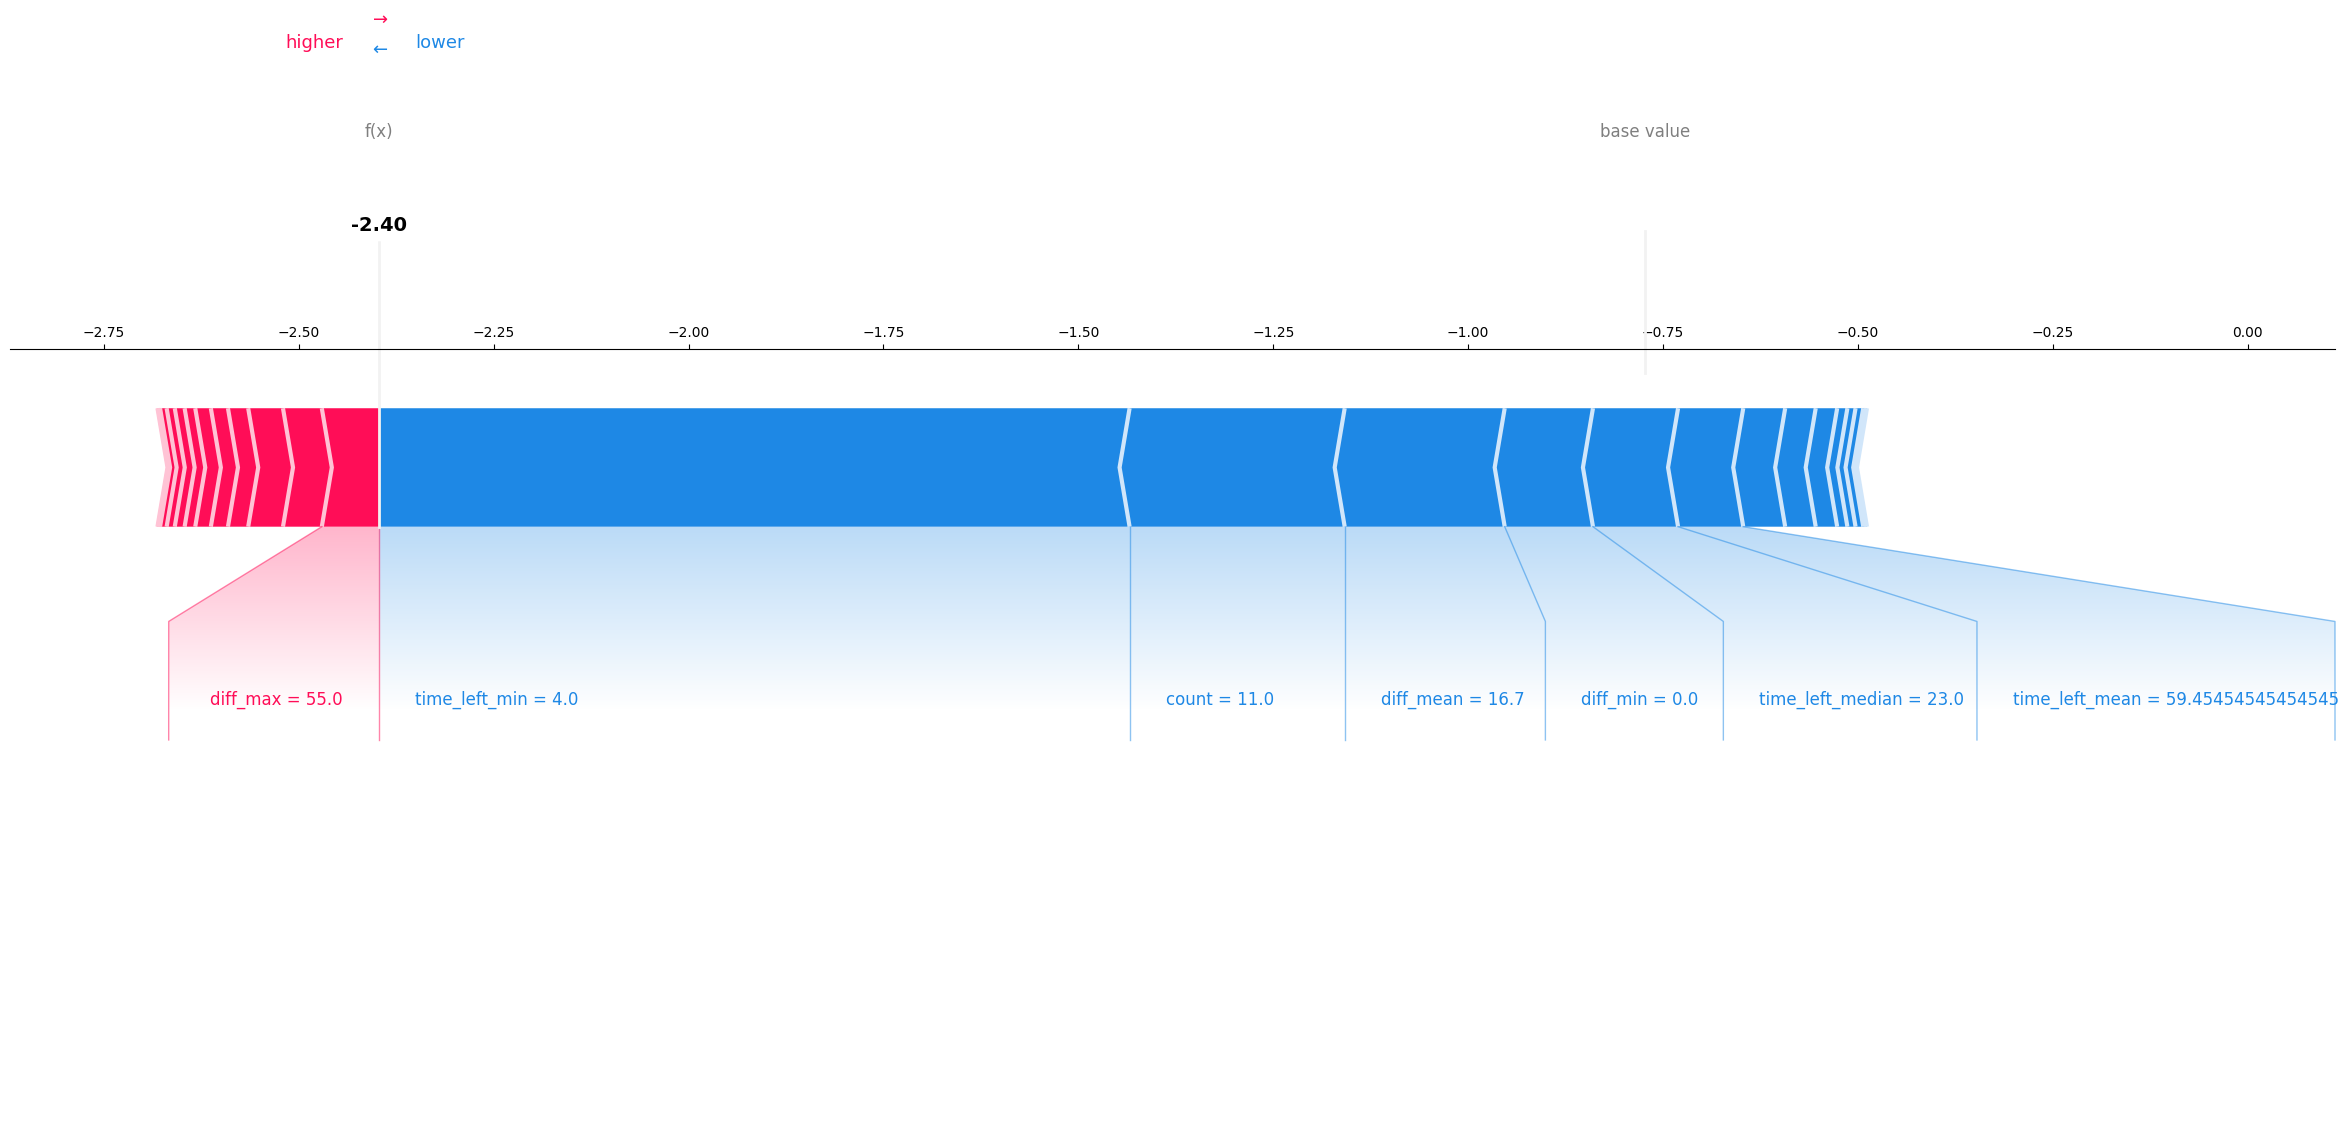

In [24]:
i = 9
partner_id = np.unique(X_val.index)[i]

shap.force_plot(
    explainer.expected_value, shap_values.values[i, :], X_val.loc[partner_id], matplotlib=True, figsize=(30, 10)
)